In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Prepare the dataset

In [5]:
import os
import random
import shutil

# Set the directory path of your original dataset
original_dataset_dir = 'train'

# Set the directory path where you want to store the training and validation datasets
base_dir = 'train'

# Create subdirectories for training and validation datasets
train_dir = os.path.join(base_dir, 'training')
os.makedirs(train_dir, exist_ok=True)

validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

# Define the class labels
classes = ['diseased', 'healthy']

# Set the percentage of images for the training dataset
train_split = 0.8

# Loop through each class and copy images to the training and validation datasets
for cls in classes:
    cls_dir = os.path.join(original_dataset_dir, cls)
    images = os.listdir(cls_dir)
    random.shuffle(images)
    
    # Calculate the number of images for the training and validation datasets
    num_train = int(len(images) * train_split)
    num_validation = len(images) - num_train
    
    # Copy images to the training dataset
    train_cls_dir = os.path.join(train_dir, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    for img in images[:num_train]:
        src = os.path.join(cls_dir, img)
        dst = os.path.join(train_cls_dir, img)
        shutil.copyfile(src, dst)
    
    # Copy images to the validation dataset
    validation_cls_dir = os.path.join(validation_dir, cls)
    os.makedirs(validation_cls_dir, exist_ok=True)
    for img in images[num_train:]:
        src = os.path.join(cls_dir, img)
        dst = os.path.join(validation_cls_dir, img)
        shutil.copyfile(src, dst)
        
    print(f'{cls}: {len(images)} images, {num_train} for training, {num_validation} for validation')


diseased: 805 images, 644 for training, 161 for validation
healthy: 904 images, 723 for training, 181 for validation


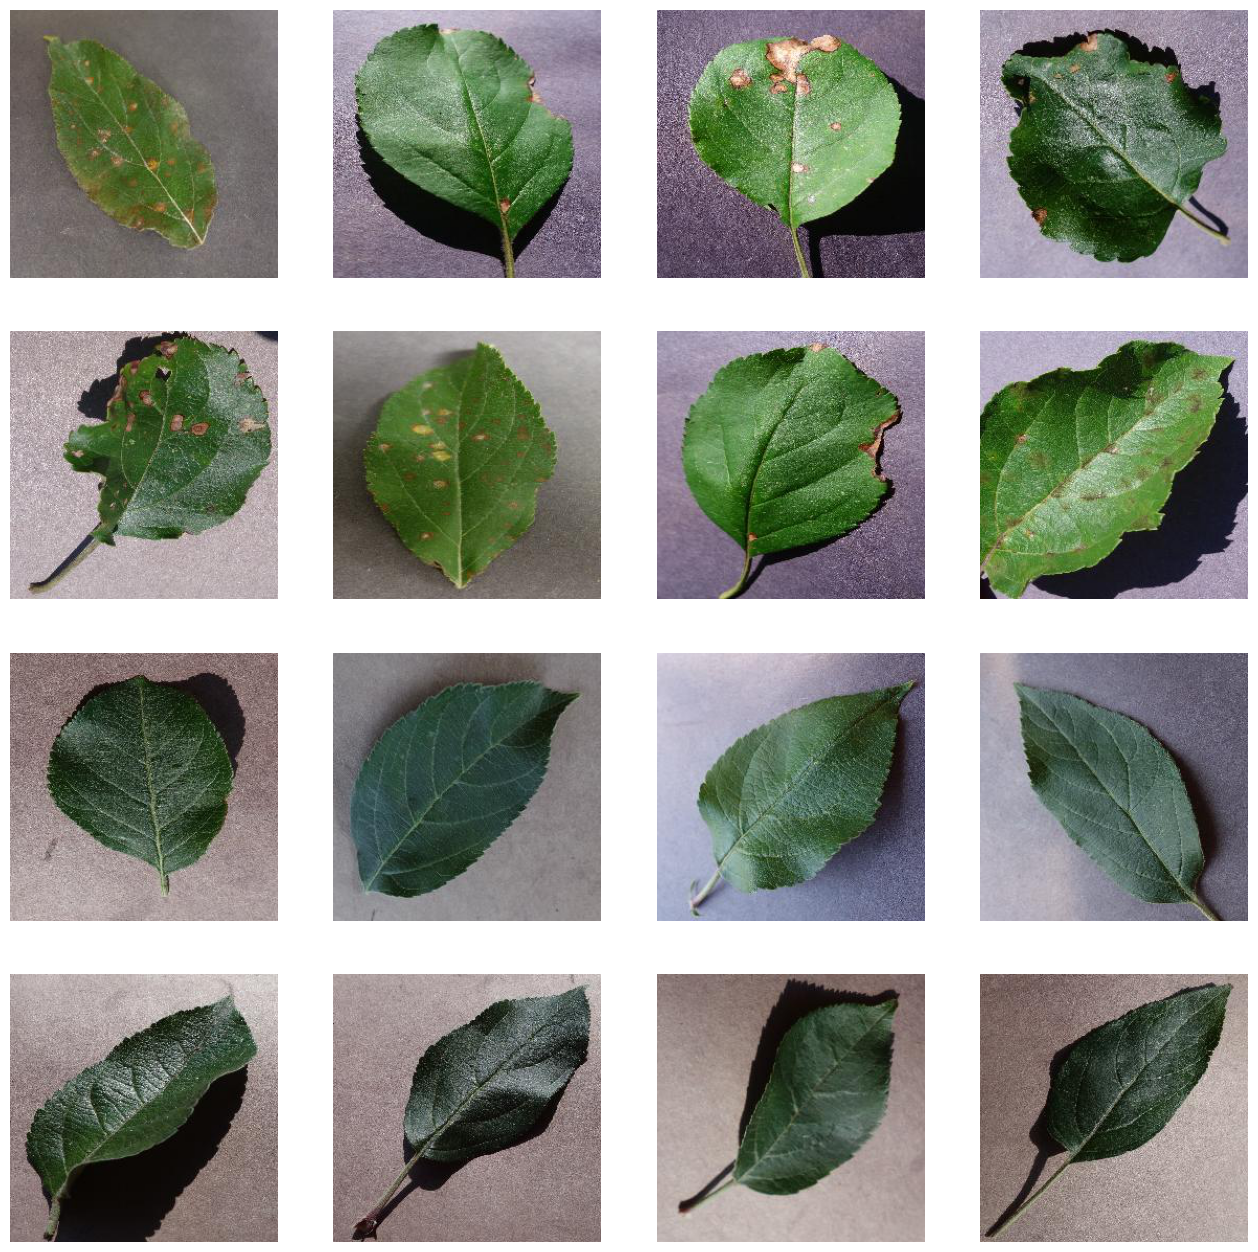

In [2]:
import os 

train_diseased_dir = "train/training/diseased"
train_healthy_dir = "train/training/healthy"

# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_diseased_fnames = os.listdir("train/training/diseased")
train_healthy_fnames = os.listdir("train/training/healthy")


next_diseased_pix = [os.path.join(train_diseased_dir, fname) 
                for fname in train_diseased_fnames[ pic_index-8:pic_index] 
               ]

next_healthy_pix = [os.path.join(train_healthy_dir, fname) 
                for fname in train_healthy_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_diseased_pix+next_healthy_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Transfer-learning

## Step 1: Image Augmentation

In [3]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale = 1.0/255. )

## Step 2: Training & Validation Sets

In [4]:
train_dir = "train/training"
validation_dir = "train/validation"

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 1367 images belonging to 2 classes.
Found 342 images belonging to 2 classes.


## Step 3: Loading Base model

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [6]:
for layer in base_model.layers:
    layer.trainable = False

## Step 4: Compile and fit

In [7]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [8]:
batch_size = 32

vgghist = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=10)

Epoch 1/10
42/42 [==============================] - 59s 1s/step - loss: 3.1390 - acc: 0.6360 - val_loss: 0.5904 - val_acc: 0.7100
Epoch 2/10
42/42 [==============================] - 59s 1s/step - loss: 0.5969 - acc: 0.7654 - val_loss: 0.1767 - val_acc: 0.9500
Epoch 3/10
42/42 [==============================] - 56s 1s/step - loss: 0.5075 - acc: 0.7848 - val_loss: 0.3050 - val_acc: 0.8950
Epoch 4/10
42/42 [==============================] - 56s 1s/step - loss: 0.3050 - acc: 0.8718 - val_loss: 0.2894 - val_acc: 0.8750
Epoch 5/10
42/42 [==============================] - 56s 1s/step - loss: 0.2877 - acc: 0.8774 - val_loss: 0.0954 - val_acc: 0.9500
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3118 - acc: 0.8718 - val_loss: 0.1430 - val_acc: 0.9350
Epoch 7/10
42/42 [==============================] - 55s 1s/step - loss: 0.2495 - acc: 0.9071 - val_loss: 0.1108 - val_acc: 0.9550
Epoch 8/10
42/42 [==============================] - 54s 1s/step - loss: 0.2230 - acc: 0.91

Validation accuracy: <b>96%</b>

## Step 5: Export the model

In [9]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


# Test the model

In [10]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     